[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/breakpoints.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239469-lesson-2-breakpoints)

# 중단점(Breakpoints)

## 복습

`human-in-the-loop`의 경우, 그래프가 실행되는 동안 출력을 보고 싶은 경우가 많습니다.

우리는 스트리밍을 통해 이를 위한 기초를 마련했습니다.

## 목표

이제 `human-in-the-loop`의 동기에 대해 이야기해보겠습니다:

(1) `Approval(승인)` - 에이전트를 중단하고, 사용자에게 상태를 노출하며, 사용자가 작업을 승인할 수 있도록 합니다

(2) `Debugging(디버깅)` - 문제를 재현하거나 피하기 위해 그래프를 되감을 수 있습니다

(3) `Editing(편집)` - 상태를 수정할 수 있습니다

LangGraph는 다양한 `human-in-the-loop` 워크플로우를 지원하기 위해 에이전트 상태를 가져오거나 업데이트하는 여러 가지 방법을 제공합니다.

먼저, 특정 단계에서 그래프를 중지하는 간단한 방법을 제공하는 [중단점](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/#simple-usage)을 소개하겠습니다.

이것이 어떻게 사용자 `승인`을 가능하게 하는지 보여드리겠습니다.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [2]:
from dotenv import load_dotenv

load_dotenv("../.env", override=True)

True

In [ ]:
import os
import getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

## 사람의 승인을 위한 중단점(Breakpoints)

모듈 1에서 다뤘던 간단한 에이전트를 다시 살펴보겠습니다.

도구 사용에 대해 우려가 있다고 가정해봅시다: 에이전트가 도구를 사용하기 전에 승인을 받고 싶습니다.

필요한 것은 단순히 `interrupt_before=["tools"]`로 그래프를 컴파일하는 것입니다. 여기서 `tools`는 우리의 도구 노드입니다.

이것은 도구 호출을 실행하는 `tools` 노드 전에 실행이 중단된다는 것을 의미합니다.

In [ ]:
from langchain_openai import ChatOpenAI


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

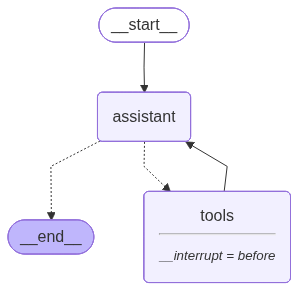

In [5]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(
    content="당신은 입력값에 대해 산술 연산을 수행하는 임무를 맡은 유용한 보조자입니다."
)


# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# Input
initial_input = {"messages": HumanMessage(content="2와 3을 곱하세요")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

2와 3을 곱하세요
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ynSz1ijfx7R7wFyu07Ma1ZXN)
 Call ID: call_ynSz1ijfx7R7wFyu07Ma1ZXN
  Args:
    a: 2
    b: 3


상태를 가져와서 다음에 호출할 노드를 확인할 수 있습니다.

이것은 그래프가 중단되었음을 확인하는 좋은 방법입니다.

In [7]:
state = graph.get_state(thread)
state.next

('tools',)

이제 유용한 트릭을 소개하겠습니다.

그래프를 `None`으로 호출하면, 마지막 상태 체크포인트부터 계속 진행됩니다!

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

명확성을 위해, LangGraph는 도구 호출이 포함된 `AIMessage`를 담고 있는 현재 상태를 다시 출력합니다.

그런 다음 도구 노드부터 시작하는 그래프의 다음 단계들을 실행합니다.

도구 노드가 이 도구 호출과 함께 실행되고, 최종 답변을 위해 챗 모델로 다시 전달되는 것을 볼 수 있습니다.

In [7]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_ynSz1ijfx7R7wFyu07Ma1ZXN)
 Call ID: call_ynSz1ijfx7R7wFyu07Ma1ZXN
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

2와 3을 곱한 결과는 6입니다.


이제 사용자 입력을 받는 특정 사용자 승인 단계와 함께 이것들을 결합해보겠습니다.

In [ ]:
# Input
initial_input = {"messages": HumanMessage(content="2와 3을 곱하세요")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# 첫 번째 중단이 발생할 때까지 그래프를 실행하십시오
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# 사용자 피드백 수집
user_approval = input("도구를 호출하시겠습니까? (yes/no):")

# 승인 확인
if user_approval.lower() == "yes":
    # 승인되면 그래프 실행을 계속하십시오
    for event in graph.stream(None, thread, stream_mode="values"):
        event["messages"][-1].pretty_print()

else:
    print("사용자에 의해 작업이 취소되었습니다.")

================================ Human Message =================================

2와 3을 곱하세요
================================== Ai Message ==================================
Tool Calls:
  multiply (call_1REOA8L06vY3smCrurWIodPP)
 Call ID: call_1REOA8L06vY3smCrurWIodPP
  Args:
    a: 2
    b: 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_1REOA8L06vY3smCrurWIodPP)
 Call ID: call_1REOA8L06vY3smCrurWIodPP
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

2와 3을 곱하면 6입니다.


### LangGraph API를 사용한 중단점

이 모듈의 `/studio` 디렉토리에서 터미널에 다음 명령어를 실행하세요:

```sh
langgraph dev
```

다음과 같은 출력을 볼 수 있습니다:

```sh
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

브라우저를 열고 Studio UI로 이동하세요: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

LangGraph API는 [중단점을 지원합니다](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_breakpoint/#sdk-initialization).

```

In [ ]:
# This is the URL of the local development server
from langgraph_sdk import get_client

client = get_client(url="http://127.0.0.1:2024")

위에서 보여진 것처럼, Studio에서 실행 중인 그래프를 컴파일할 때 `interrupt_before=["node"]`를 추가할 수 있습니다.

하지만 API를 사용하면 stream 메서드에 직접 `interrupt_before`를 전달할 수도 있습니다.

In [ ]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get("messages", [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '2a3b1e7a-f6d9-44c2-a4b4-b7f67aa3691c', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_ElnkVOf1H80dlwZLqO0PQTwS', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 't

이제 이전에 했던 것처럼 `thread_id`와 `None`을 입력으로 전달하여 중단점부터 진행할 수 있습니다!

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get("messages", [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_ElnkVOf1H80dlwZLqO0PQTwS', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-89ee14dc-5f46-4dd9-91d9-e922c4a23572-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_ElnkVOf1H80dlwZLqO0PQTwS', 'type': 'tool_call'}], 'invalid_tool_